In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm

import pycbc
from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter.resample import resample_to_delta_t
from pycbc.events import ThresholdCluster
from pycbc.filter import matched_filter, resample_to_delta_t, highpass_fir
from pycbc.vetoes import power_chisq
from pycbc.filter.matchedfilter import sigma
from pycbc.events.ranking import newsnr

from tempgen import get_wave, get_wave_amp, get_ht
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import tukey

In [3]:
df = pd.read_csv('Durations.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,Qi,ri,M,id,hpamp,hcamp,dur
0,-8.0,1.0,1,0,2.451429e-14,2.130521e-14,20.0
1,-8.0,2.0,1,1,6.128573e-15,5.327107e-15,20.0
2,-8.0,3.0,1,2,2.723810e-15,2.367961e-15,20.0
3,-8.0,4.0,1,3,1.532143e-15,1.332179e-15,50.0
4,-8.0,5.0,1,4,9.805716e-16,8.527236e-16,50.0
...,...,...,...,...,...,...,...
145,-5.0,2.0,50,145,7.660661e-16,6.697145e-16,2501.0
146,-5.0,3.0,50,146,3.404708e-16,2.985468e-16,2501.0
147,-5.0,4.0,50,147,1.915124e-16,1.684370e-16,2501.0
148,-5.0,5.0,50,148,1.225660e-16,1.081227e-16,2501.0


In [4]:
flow = 20
fhigh = 250


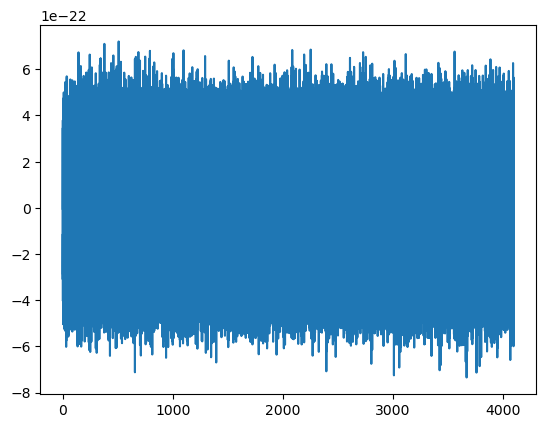

In [5]:
strain = TimeSeries(np.loadtxt('Gaussian_4096s_512Hz.txt'), delta_t=1/512)
strain = strain.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
strain.plot()

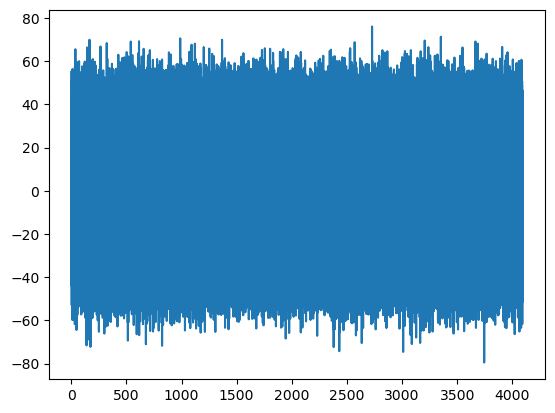

In [6]:
strain.whiten(4,4).plot()

In [35]:
strain = strain.time_slice(2,100)
strain.start_time=0

In [36]:
def SNR(Temp, Strain, time=20, nbins=26, crop = 5, ret='reg'):
    
    
    strain = Strain.copy()
    temp = Temp.copy()
        
    ## if time is none, then template is not injected
    if time is not None:
        temp.start_time=time
        strain = strain.inject(temp)
        temp.start_time=0
    
    
    PSD = interpolate(strain.psd(4), strain.delta_f)
    PSD = inverse_spectrum_truncation(PSD, int(4 * strain.sample_rate), trunc_method='hann')
    #################################################
    
    temlen = temp.duration
    temp.resize(len(strain))
    temp = temp.cyclic_time_shift(strain.duration-temlen/2)
    
    snr = abs(matched_filter(temp, strain, psd=PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh))   
    
    if ret != 'reg':
        
        chisq = power_chisq(temp, strain, 26, PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh, return_bins=False)/(26*2-2)
        
        snr = TimeSeries(newsnr(snr, chisq), delta_t=1/512)
    return snr.crop(5,5)

## Checking if cropping lengths change SNR

### Example Tid = 5

First plotting and checking SNR

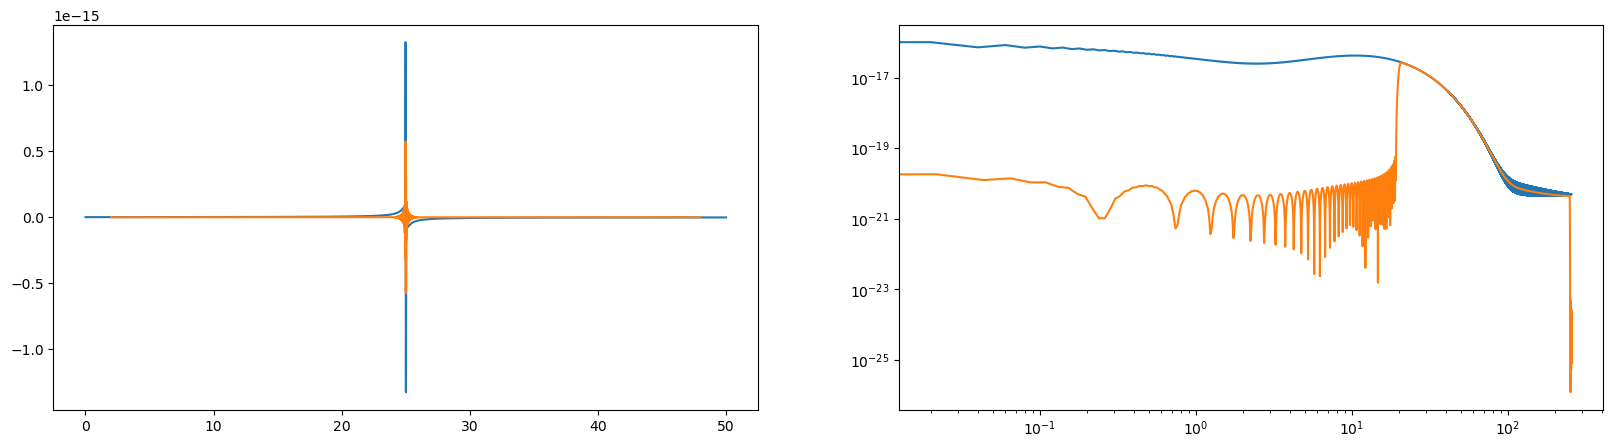

In [13]:
hd = h5py.File('Temps.hdf5', 'r')

Hp = hd['Hp']
Hc = hd['Hc']

fig, ax = plt.subplots(1,2, figsize=(20, 5))

k = '3'

j = df[df['id'] == int(k)].iloc[0]
M = j['M']
r = j['ri']
Q = j['Qi']
dur = j['dur']
    
hp = TimeSeries(np.array(Hc[k]), delta_t=1/512)
hf = hp.to_frequencyseries()
ax[0].plot(hp.sample_times, hp)
ax[1].plot(hf.sample_frequencies, abs(hf))
    
hp = hp.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
hf = hp.to_frequencyseries()  
ax[0].plot(hp.sample_times, hp)
ax[1].plot(hf.sample_frequencies, abs(hf))
    


plt.xscale('log')
plt.yscale('log')

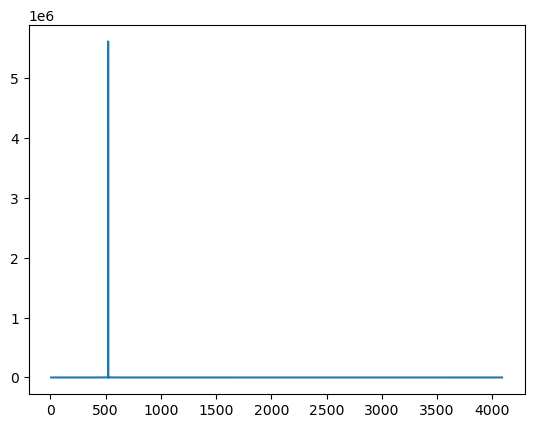

In [14]:
snr = SNR(hp, strain)
snr.plot()

error within SNR with different template lengths = 26%


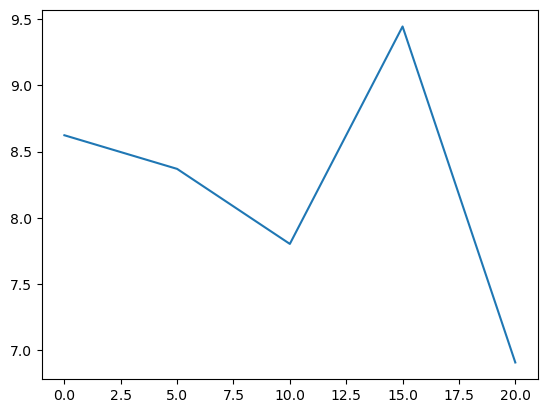

In [15]:
temp = TimeSeries(np.array(Hc[k]), delta_t=1/512)

slices = [0, 5, 10, 15, 20]
snrs = []

for ts in slices:
    
    hp = temp.time_slice(ts, temp.duration-ts)/700000
    hp = hp.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
    
    snr = max(SNR(hp, strain))
    snrs.append(snr)

plt.plot(slices, snrs)

percent = (max(snrs) - min(snrs))/max(snrs)*100
print('error within SNR with different template lengths = ' + str(int(percent)) + '%')

8.018482106991833
8.07151323527357
8.013814213815444
8.06667308428051
8.08579781841871
error within Dh with different template lengths = 11%


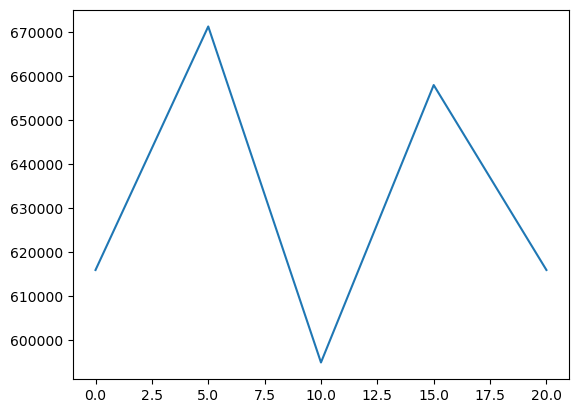

In [92]:
temp = TimeSeries(np.array(Hc[k]), delta_t=1/512)

slices = [0, 5, 10, 15, 20]
Dh = np.array([0.88,0.959,0.85,0.94,0.88])*700000
snrs = []
i=0

for ts in slices:
    
    
    hp = temp.time_slice(ts, temp.duration-ts)/Dh[i]
    hp = hp.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
    
    snr = max(SNR(hp, strain))
    snrs.append(snr)
    print(snr)
    i += 1
    
plt.plot(slices, Dh)

percent = (max(Dh) - min(Dh))/max(Dh)*100
print('error within Dh with different template lengths = ' + str(int(percent)) + '%')

### Timeslice changes the injection position. I will make injections such that the peak is at the same time 

In [110]:
temp = TimeSeries(np.array(Hc[k]), delta_t=1/512)
slices = [0, 5, 10, 15, 20]

snrs = []

for ts in slices:
    
    hp = temp.time_slice(ts, temp.duration-ts)/750000
    hp = hp.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
    
    time = 50 + (50-hp.duration)/2
    snr = max(SNR(hp, strain, time=time))
    snrs.append(snr)
    
    print(snr)

percent = (max(snrs) - min(snrs))/max(snrs)*100
print('error within SNR with different template lengths = ' + str(int(percent)) + '%')

8.049007950234582
8.049378858806255
8.049203388188332
8.049054496767846
8.04904047615149
error within SNR with different template lengths = 0%


#### snr is the same which means Dh = 750000 pc for all of the template lengths

let me check if simply chaning injection time varies the SNR by a lot

6.94567138239605
8.08805819022062
7.267955099121868
9.08563280831562
6.296010154615613
error within SNR with different template lengths = 30%


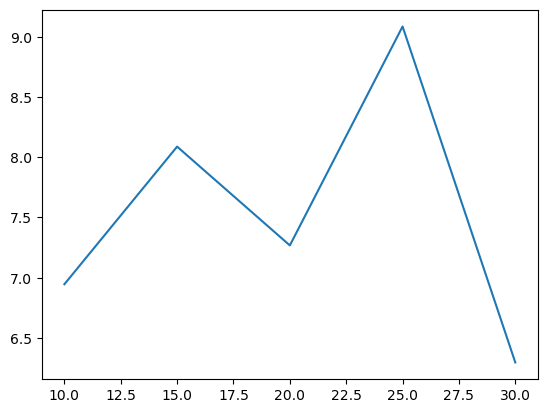

In [115]:
temp = TimeSeries(np.array(Hc[k]), delta_t=1/512)

times = [10, 15, 20, 25, 30]

snrs = []

i=0
for ts in times:
    
    hp = temp.copy()/670000
    hp = hp.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
    
    time = times[i]
    snr = max(SNR(hp, strain, time=time))
    snrs.append(snr)
    
    print(snr)
    i += 1

percent = (max(snrs) - min(snrs))/max(snrs)*100
print('error within SNR with different template lengths = ' + str(int(percent)) + '%')

plt.plot(times, snrs)